1. Load all the necessary functions

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import requests
import torch.nn as nn
import torch.optim as optim
import random
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.2 MB/s eta 0:00:00


2. import CNN/Daily Mail dataset, from https://huggingface.co/datasets/cnn_dailymail

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_dataset
import nltk
nltk.download('punkt')


# preprocess text
def preprocess_text(examples):
    return {'highlights': [[word_tokenize(sent) for sent in sent_tokenize(text)] for text in examples['highlights']],
            'article': [[word_tokenize(sent) for sent in sent_tokenize(text)] for text in examples['article']]}

# datasets
dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:500]")
train_data = dataset
val_data = load_dataset('cnn_dailymail', '3.0.0', split="validation[:100]")
test_data = load_dataset('cnn_dailymail', '3.0.0', split="test[:100]")


# summaries
train_summaries = [example['highlights'] for example in train_data]
train_texts = [example['article'] for example in train_data]

val_summaries = [example['highlights'] for example in val_data]
val_texts = [example['article'] for example in val_data]

test_summaries = [example['highlights'] for example in test_data]
test_texts = [example['article'] for example in test_data]

data_sets = [('Train', train_data, train_summaries, train_texts),
             ('Validation', val_data, val_summaries, val_texts),
             ('Test', test_data, test_summaries, test_texts)]

for name, data, summary, text in data_sets:
    print(f"\n{name} Data: {len(data)} examples, {len(summary)} summaries, {len(text)} texts")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]


Train Data: 500 examples, 500 summaries, 500 texts

Validation Data: 100 examples, 100 summaries, 100 texts

Test Data: 100 examples, 100 summaries, 100 texts


In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import torch.nn.utils.rnn as rnn_utils
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# maximum length for each sentence
max_length = 512
max_summary_length = 100

# check for non-string elements in train_texts
vocab_input = {'<OOV>': 0, '<sos>': 1}
word_counter_input = Counter(word for text_list in train_texts for text in text_list for word in text)
for word, count in word_counter_input.items():
    if word not in vocab_input:
        vocab_input[word] = len(vocab_input)

vocab_target = {'<OOV>': 0, '<sos>': 1}
word_counter_target = Counter(word for summary_list in train_summaries for summary in summary_list for word in summary)
for word, count in word_counter_target.items():
    if word not in vocab_target:
        vocab_target[word] = len(vocab_target)

def sentences_2_sequence_inputs(sentences, max_length):
    flattened = [word for sentence in sentences for word in sentence]
    return [vocab_input.get(word, vocab_input['<OOV>']) for word in flattened[:max_length]]

def sentences_2_sequence_targets(sentences, max_length):
    flattened = [word for sentence in sentences for word in sentence]
    return [vocab_target.get(word, vocab_target['<OOV>']) for word in flattened[:max_length]]


train_sequences_input = [sentences_2_sequence_inputs(text, max_length) for text in train_texts]
val_sequences_input = [sentences_2_sequence_inputs(text, max_length) for text in val_texts]
test_sequences_input = [sentences_2_sequence_inputs(text, max_length) for text in test_texts]

train_sequences_target = [sentences_2_sequence_targets(summary, max_summary_length) for summary in train_summaries]
val_sequences_target = [sentences_2_sequence_targets(summary, max_summary_length) for summary in val_summaries]
test_sequences_target = [sentences_2_sequence_targets(summary, max_summary_length) for summary in test_summaries]

class CustomDataset(Dataset):
    def __init__(self, sequences_input, sequences_target, max_length):
        self.sequences_input = sequences_input
        self.sequences_target = sequences_target
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, index):
        input_sequence = self.sequences_input[index]
        target_summary = self.sequences_target[index]
        input_sequence = self.pad_sequence(input_sequence, self.max_length)
        target_summary = self.pad_sequence(target_summary, self.max_length)
        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_summary, dtype=torch.long)
        return input_tensor, target_tensor

    def pad_sequence(self, sequence, max_length):
        if len(sequence) < max_length:
            sequence = sequence + [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        return sequence


train_dataset = CustomDataset(train_sequences_input, train_sequences_target, max_length)
val_dataset = CustomDataset(val_sequences_input, val_sequences_target, max_length)
test_dataset = CustomDataset(test_sequences_input, test_sequences_target, max_length)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch_inputs, batch_targets in train_loader:
    break

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0, :]
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1.detach()
        return outputs

    def generate_summary(self, src, max_len=100):
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = torch.tensor([vocab_input['<sos>']]*batch_size).to(device)
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            top1 = output.argmax(1)
            input = top1
        return outputs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_input_dim = len(vocab_input)
decoder_output_dim = len(vocab_target)
embedding_dim = 100
hidden_dim = 256
num_layers = 2
dropout = 0.5

encoder = Encoder(encoder_input_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)
decoder = Decoder(decoder_output_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training Epochs:  20%|██        | 4/20 [05:56<23:53, 89.58s/it]


Epoch 5/20
Training Loss: 1.0743 - Training Accuracy: 0.8063
Validation Loss: 1.1903 - Validation Accuracy: 0.8069


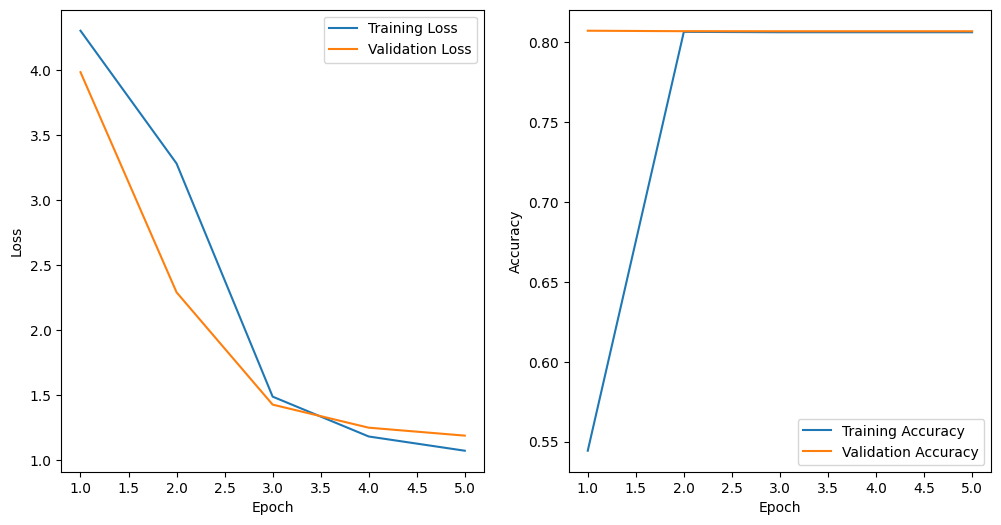

Training Epochs:  45%|████▌     | 9/20 [13:25<16:29, 89.93s/it]


Epoch 10/20
Training Loss: 0.8329 - Training Accuracy: 0.8145
Validation Loss: 0.9716 - Validation Accuracy: 0.8182


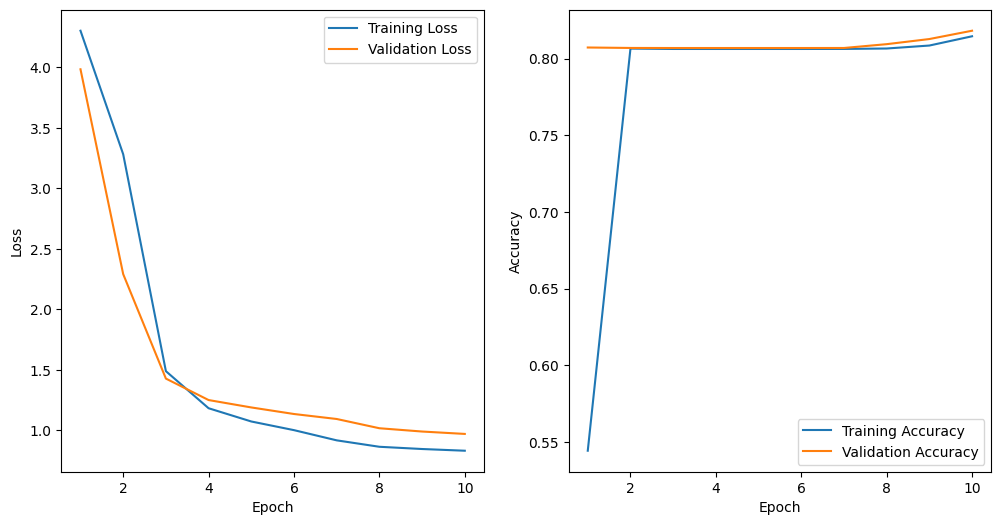

Training Epochs:  70%|███████   | 14/20 [20:49<08:53, 88.93s/it]


Epoch 15/20
Training Loss: 0.6989 - Training Accuracy: 0.8280
Validation Loss: 0.8153 - Validation Accuracy: 0.8270


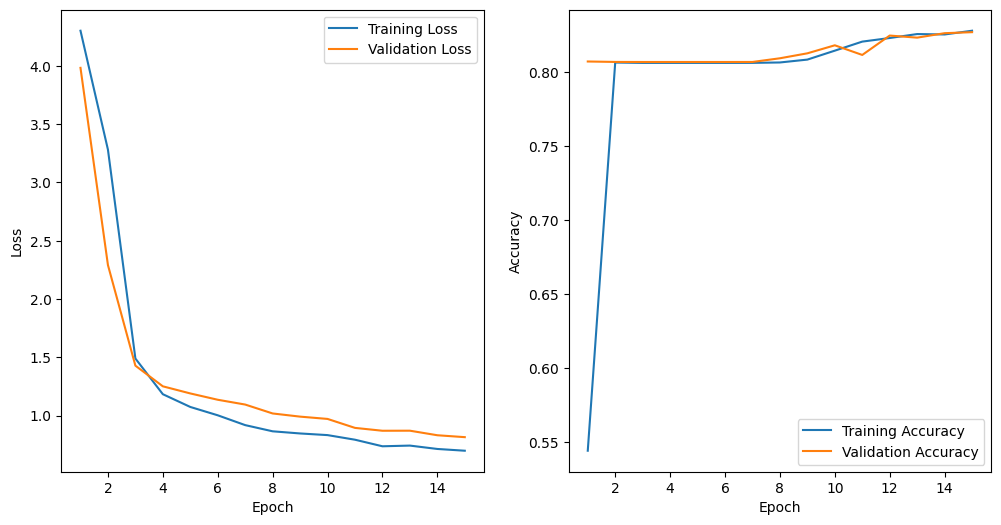

Training Epochs:  95%|█████████▌| 19/20 [28:14<01:28, 88.59s/it]


Epoch 20/20
Training Loss: 0.6723 - Training Accuracy: 0.8295
Validation Loss: 0.7881 - Validation Accuracy: 0.8277


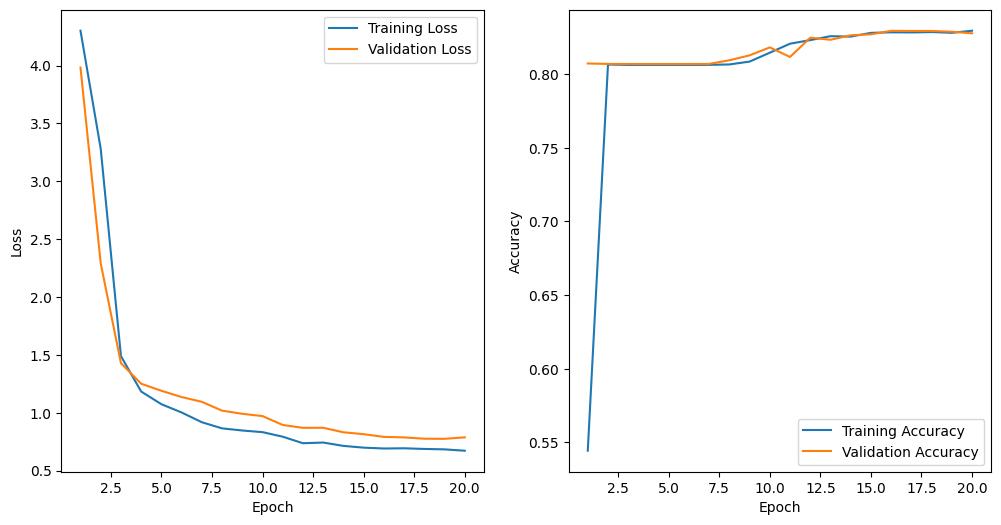

Training Epochs: 100%|██████████| 20/20 [29:41<00:00, 89.10s/it]


In [6]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def calculate_accuracy(preds, targets):
    return (torch.max(preds, 1)[1] == targets).sum().item() / len(targets)

def train(model, num_epochs, train_loader, val_loader, print_every=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in tqdm(range(1, num_epochs + 1), desc='Training Epochs'):
        # training
        model.train()
        running_train_loss = 0.0
        correct_train = 0

        for batch_inputs, batch_targets in train_loader:
            start_token = torch.zeros((batch_targets.size(0), 1), dtype=batch_targets.dtype).to(device)
            decoder_input = torch.cat((start_token, batch_targets[:, :-1]), dim=1).to(device)

            decoder_target = batch_targets[:, 1:].to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs, decoder_input)
            outputs = outputs[:, :-1, :]
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), decoder_target.reshape(-1))

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            correct_train += (outputs.argmax(2) == decoder_target).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(correct_train / (len(train_loader.dataset) * decoder_target.shape[1]))

        # validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                start_token = torch.zeros((batch_targets.size(0), 1), dtype=batch_targets.dtype).to(device)
                decoder_input = torch.cat((start_token, batch_targets[:, :-1]), dim=1).to(device)

                decoder_target = batch_targets[:, 1:].to(device)

                outputs = model(batch_inputs, decoder_input)
                outputs = outputs[:, :-1, :]
                loss = criterion(outputs.reshape(-1, outputs.shape[-1]), decoder_target.reshape(-1))

                running_val_loss += loss.item()
                correct_val += (outputs.argmax(2) == decoder_target).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(correct_val / (len(val_loader.dataset) * decoder_target.shape[1]))

        # print and plot results every 5 epochs
        if epoch % print_every == 0:
            print(f"\nEpoch {epoch}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracies[-1]:.4f}")
            print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracies[-1]:.4f}")
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(np.arange(1, epoch + 1), train_losses, label='Training Loss')
            plt.plot(np.arange(1, epoch + 1), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(np.arange(1, epoch + 1), train_accuracies, label='Training Accuracy')
            plt.plot(np.arange(1, epoch + 1), val_accuracies, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train(model, num_epochs, train_loader, val_loader)
